# setup the notebook

In [1]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount("/content/drive")

!wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
import colab_github
colab_github.github_auth(persistent_key=True)

%cd /content/drive/MyDrive/Colab\ Notebooks/EECS_442_HOI

Mounted at /content/drive
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAICeyklL46g42c+kOiDGQYpBIkUVa8Oott1qwDIqq8fti root@8ae8a1039f30

Please use SSH method to clone repo.
/content/drive/MyDrive/Colab Notebooks/EECS_442_HOI


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 8.2 MB/s eta 0:00:00


# loading data

In [3]:
from vcoco.dataloader_original import get_train_val_test_loaders
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch

added /content/drive/MyDrive/Colab Notebooks/EECS_442_HOI/vcoco/coco/PythonAPI to pythonpath


In [4]:
train_loader, test_loader = get_train_val_test_loaders(32)

loading annotations into memory...
Done (t=4.64s)
creating index...
index created!
load hold 1 / 26
total test image number 3608
load image from  0 to 300


100%|██████████| 300/300 [01:05<00:00,  4.61it/s]


load hold 1 / 26
total test image number 3608
load image from  300 to 330


100%|██████████| 30/30 [00:06<00:00,  4.79it/s]


## visualize the loaded data

tensor([[ 0.3682,  0.5628],
        [ 0.3722,  0.5794],
        [-0.7812, -0.7812],
        [-0.7812, -0.7812],
        [ 0.3749,  0.1220]])


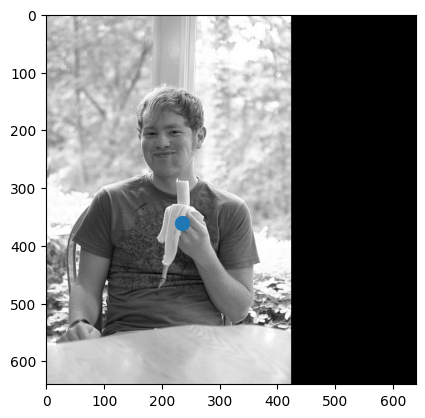

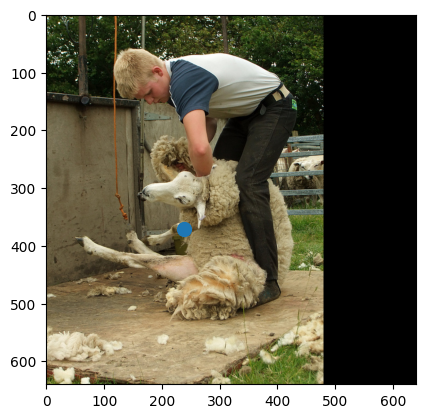

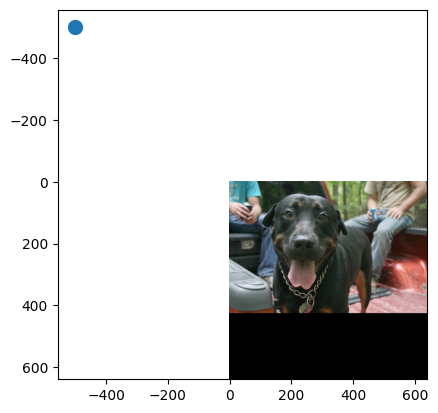

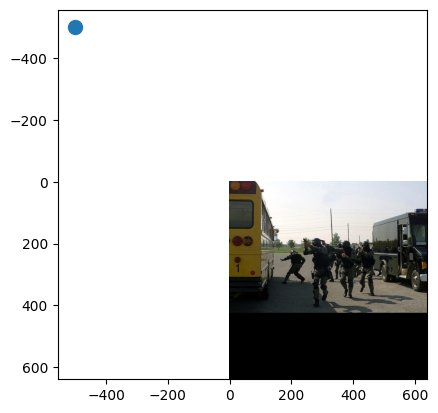

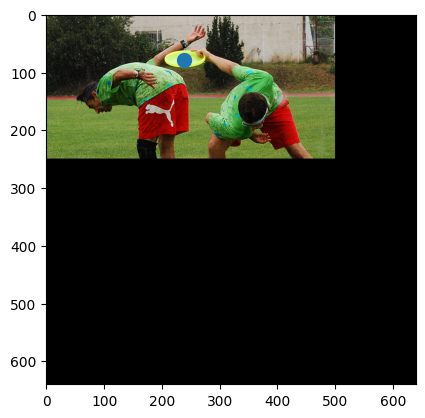

In [5]:
# visualize some data
# load ith batch to varialbe X and y
for i ,(X, y) in enumerate(test_loader):

  print(y[0:5, :]) # print the first 5 labels
  y = (y * 640).int()
  if i == 0:
    for j in range(5):
      plt.figure()
      plt.imshow(X[j].permute(1,2,0))
      plt.plot(y[j][0], y[j][1], marker='.', markersize=20)

# Training interaction propose network

In [21]:
from pipeline import train_model, extract_feature
from MLP_POI import MLP_POI
import torch.optim as optim
import torch.nn as nn

print("PyTorch Version: ",torch.__version__)
# print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

dataloaders = {'train': train_loader, 'test': test_loader}

# create MLP
input_size = 2048 * 7 * 7 # size of layer 4 feature
MLP = MLP_POI(input_size, [1024, 512, 2])
MLP = MLP.to(device)

# define constant for hyperparameters
LR = 1e-1 # learning rate
DECAY = 0  #1e-2 # decay rate

optimizer = optim.Adam(MLP.parameters(), lr=LR, weight_decay=DECAY)
criterion = nn.MSELoss()

MLP, _, _ = train_model(MLP, dataloaders, criterion, optimizer, device=device, num_epochs = 2, save_dir=None)

PyTorch Version:  2.1.0+cu118
Epoch 0/1
----------


  0%|          | 0/10 [00:34<?, ?it/s]


KeyboardInterrupt: ignored

## visualize training result

In [7]:
# visualize result
# load ith batch to varialbe X and y
for j ,(X, y) in enumerate(test_loader):
  features = extract_feature(X.to(device), device)['layer4']
  result = MLP(features)
  y = (y * 640).int()
  for i in range(len(X)):
    plt.figure()
    plt.imshow(X[i].permute(1,2,0))
    plt.plot(result[i][0].cpu().detach().numpy(), result[i][1].cpu().detach().numpy(), marker='.', markersize=20)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
criterion = nn.MSELoss(reduction='sum')
for i, (inputs, labels) in enumerate(dataloaders['train']):
  if i == 0:
    inputs = inputs[0:4,:].to(device)
    labels = labels[0:4,:].to(device)
    features = extract_feature(inputs, device)['layer4']
    # print(features)
    outputs = MLP(features)
    print(outputs)
    print(labels)
    loss = criterion(outputs, labels)
    print(loss)
    diff = (outputs - labels) * 640
    print(diff)
    norm = torch.linalg.norm(diff, ord=2, dim=1, keepdim=True)
    print(norm)
    norm = torch.sum(norm)
    print(norm)


    break

tensor([[0.0000, 0.0000],
        [0.0005, 0.0001],
        [0.0000, 0.0000],
        [0.0000, 0.0000]], grad_fn=<AddmmBackward0>)
tensor([[ 0.3250,  0.2070],
        [-0.7812, -0.7812],
        [ 0.6263,  0.3759],
        [-0.7812, -0.7812]])
tensor(3.1243, grad_fn=<MseLossBackward0>)
tensor([[-207.9900, -132.5100],
        [ 500.3113,  500.0717],
        [-400.8050, -240.5450],
        [ 500.0000,  500.0000]], grad_fn=<MulBackward0>)
tensor([[246.6145],
        [707.3776],
        [467.4469],
        [707.1068]], grad_fn=<LinalgVectorNormBackward0>)
tensor(2128.5459, grad_fn=<SumBackward0>)


# training using VGG CNN

In [ ]:
import copy

def train_CNN(model, dataloaders, criterion, optimizer, device='cpu', vis=False, save_dir = None, num_epochs=25, model_name='MLP_POI'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # zero the grad

                # predict the point of interest
                outputs = model(inputs)

                # compute loss
                # preds = torch.argmax(outputs, dim=1)
                loss = criterion(outputs, labels)

                # print(inputs[0,0,0,0])
                # print(type(loss))
                # print(type(labels))
                if phase == 'train':
                  loss.backward()
                  optimizer.step()


                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)

                # hard code correct constraint
                # if difference of l2 norm between GT poi and pred poi < 50
                diff = torch.linalg.norm((outputs - labels)*640, ord=2, dim=1)
                correct_pred = torch.where(diff < 50, 1, 0)
                running_corrects += torch.count_nonzero(correct_pred)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # visualize the prediction result
                if vis:
                  for i in len(inputs):
                    plt.figure()
                    plt.imshow[inputs[i].permute(1,2,0)]
                    plt.plot(labels[0][0], labels[0][1], marker='.', markersize=20)


                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained
                # weights.
                # You should download the trained weights to your local machine.
                # Later, you can load these weights directly without needing to
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'test':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)

    print('Best test Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

In [ ]:
from cnn import CNN
print("PyTorch Version: ",torch.__version__)
# print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

dataloaders = {'train': train_loader, 'test': test_loader}

# create MLP
CNN = CNN().to(device)

# define constant for hyperparameters
LR = 1e-1 # learning rate
DECAY = 0  #1e-2 # decay rate

optimizer = optim.Adam(MLP.parameters(), lr=LR, weight_decay=DECAY)
criterion = nn.MSELoss()

MLP, _, _ = train_model(MLP, dataloaders, criterion, optimizer, device=device, num_epochs = 5, save_dir=None)